# Plotting birdcall data in a specific region

This notebook uses `cartopy` and `shapely` to plot birdcall datapoints on a map.

Useful links:

- https://www.pymc-labs.io/blog-posts/spatial-gaussian-process-01/
- https://uoftcoders.github.io/studyGroup/lessons/python/cartography/lesson/
- https://scitools.org.uk/cartopy/docs/latest/getting_started/index.html
- https://shapely.readthedocs.io/en/stable/manual.html

## Setup

In [1]:
# make sure you have the training metadata downloaded locally
! gcloud storage cp \
    gs://birdclef-2022/raw/birdclef-2022/train_metadata.csv \
    ../data/raw/birdclef-2022/

Copying gs://birdclef-2022/raw/birdclef-2022/train_metadata.csv to file://../data/raw/birdclef-2022/train_metadata.csv
  Completed files 1/1 | 3.1MiB/3.1MiB                                          

Average throughput: 7.2MiB/s


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cartopy.io import shapereader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point, Polygon

In [3]:
df = pd.read_csv("../data/raw/birdclef-2022/train_metadata.csv")
subset_df = df[["primary_label", "latitude", "longitude"]].dropna()
subset_df.head()

,primary_label,latitude,longitude
0,afrsil1,12.3910,-1.4930
1,afrsil1,19.8801,-155.7254
2,afrsil1,16.2901,-16.0321
3,afrsil1,17.0922,54.2958
4,afrsil1,21.4581,-157.7252


## Reading in geometries

Use cartopy to read in shape files from [natural eath](https://www.naturalearthdata.com/).
We'll focus our exploration on Georgia.
We manually find the extents of the map (x and y limits) so that our plot looks reasonable.

In [4]:
reader = shapereader.Reader(
    shapereader.natural_earth(
        resolution="50m", category="cultural", name="admin_1_states_provinces"
    )
)
georgia = [
    s
    for s in reader.records()
    if s.attributes["admin"] == "United States of America"
    and s.attributes["name"] == "Georgia"
][0]

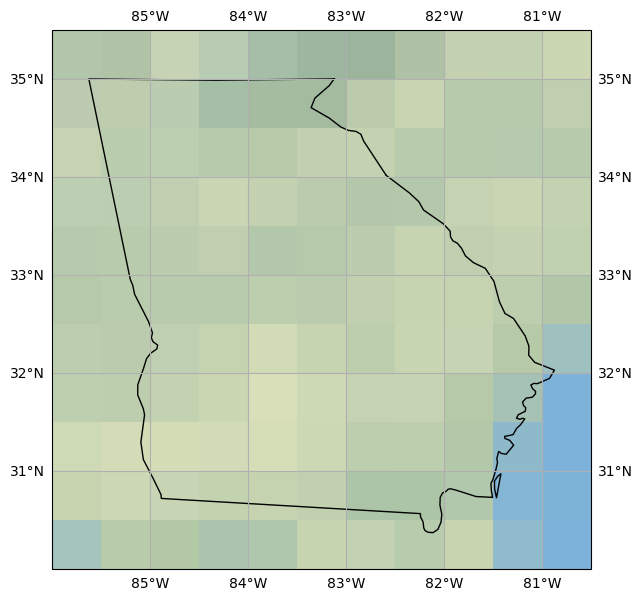

In [5]:
fig = plt.figure(figsize=(12, 7))
projection = ccrs.PlateCarree()

ax = plt.axes(projection=projection)
ax.stock_img()
# xlim and ylim for Georgia, manually found
ax.set_xlim(-86, -80.5)
ax.set_ylim(30, 35.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.add_feature(
    cfeature.ShapelyFeature([georgia.geometry], projection),
    edgecolor="k",
    facecolor=(1, 1, 1, 0),
)
plt.show()

We can use the shape file's geometry to check if a point is inside of the state's polygon. We can also do other operations, like finding intersection between shapes.

In [6]:
points_in_ga = subset_df.apply(
    lambda x: georgia.geometry.contains(Point(x.longitude, x.latitude)), axis=1
)
ga_df = subset_df[points_in_ga]
ga_df.primary_label.value_counts()

norcar     6
comgal1    3
osprey     3
grbher3    2
hoomer     2
houfin     2
laugul     2
normoc     2
bcnher     1
belkin1    1
bkbplo     1
cangoo     1
gwfgoo     1
moudov     1
sora       1
Name: primary_label, dtype: int64

We'll plot our map again, this time with data points within our geographical boundaries.

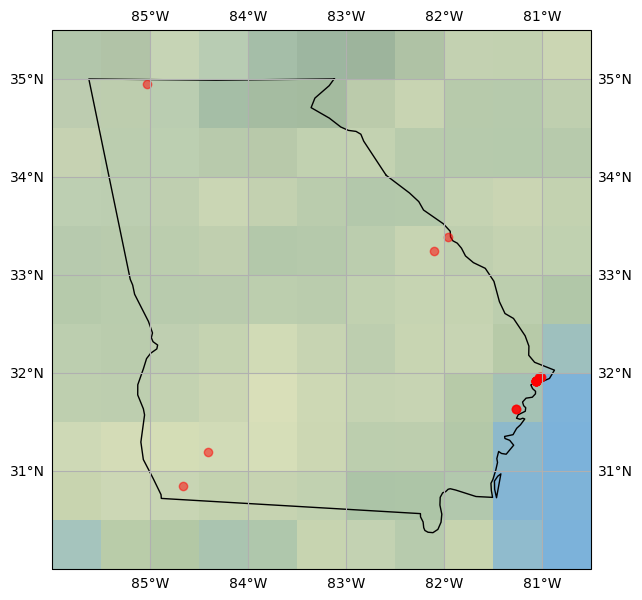

In [7]:
fig = plt.figure(figsize=(12, 7))
projection = ccrs.PlateCarree()

ax = plt.axes(projection=projection)
ax.stock_img()
ax.set_xlim(-86, -80.5)
ax.set_ylim(30, 35.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.add_feature(
    cfeature.ShapelyFeature([georgia.geometry], projection),
    edgecolor="k",
    facecolor=(1, 1, 1, 0),
)

# add points from the georgia subset
for i, row in ga_df.iterrows():
    ax.plot(
        row.longitude,
        row.latitude,
        "o",
        color="r",
        transform=ccrs.PlateCarree(),
        alpha=0.5,
    )

plt.show()

## Generating a lattice

For bayesian analysis, it makes sense to discretize our geographical data into a regular lattice.
This will make it easier to incorporate other sources of information such as population density and temperature.
Other methods of data smoothing such as [Kernel Density Estimates of Species Distributions on the Scikit-Learn page](https://scikit-learn.org/stable/auto_examples/neighbors/plot_species_kde.html#sphx-glr-auto-examples-neighbors-plot-species-kde-py) do not need this pre-processing.

In [8]:
def generate_grid(df, shape, map_dims, grid_dims):
    xmin, xmax, ymin, ymax = map_dims
    length, width = grid_dims

    # generate a grid of polygons that intersect with the provided shape
    polygons = {}
    cols = list(np.arange(xmin, xmax + width, width))
    rows = list(np.arange(ymin, ymax + length, length))
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygon = Polygon(
                [(x, y), (x + width, y), (x + width, y + length), (x, y + length)]
            )
            if shape.geometry.intersects(polygon):
                polygons[f"{x}_{y}"] = polygon

    # now generate a new dataframe where points are contained within the shape
    points = df.apply(
        lambda x: shape.geometry.contains(Point(x.longitude, x.latitude)), axis=1
    )
    res_df = subset_df[points].copy()

    # add the appropriate grid for each point
    res_df["grid"] = res_df.apply(
        lambda x: [
            k for k, p in polygons.items() if p.contains(Point(x.longitude, x.latitude))
        ][0],
        axis=1,
    )
    return res_df, polygons


ga_df, polygons = generate_grid(subset_df, georgia, [-86, -80.5, 30, 35.5], [0.5, 0.5])
print(f"{len(polygons)} grid items")
ga_df.head()

79 grid items


,primary_label,latitude,longitude,grid
531,bcnher,31.9237,-81.0559,-81.5_31.5
908,belkin1,31.9237,-81.0559,-81.5_31.5
1103,bkbplo,31.9237,-81.0559,-81.5_31.5
2458,cangoo,33.2490,-82.1030,-82.5_33.0
3267,comgal1,31.6296,-81.2669,-81.5_31.5


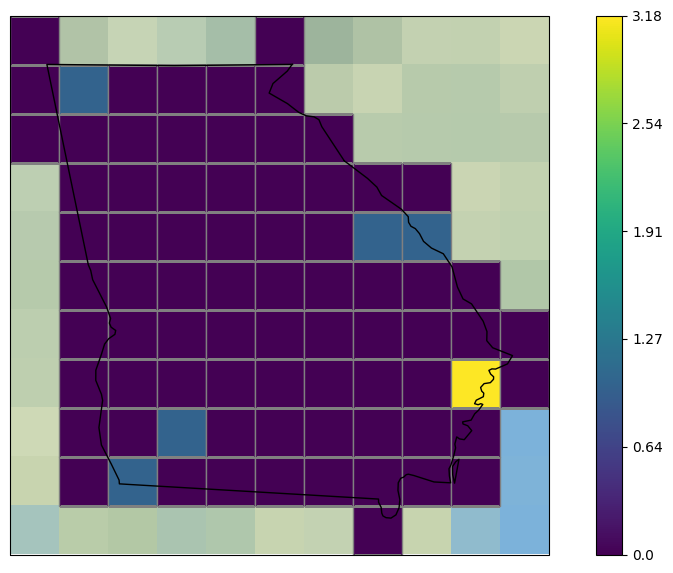

In [9]:
fig = plt.figure(figsize=(12, 7))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.stock_img()
ax.set_xlim(-86, -80.5)
ax.set_ylim(30, 35.5)


# we log scale the counts so that we can see the distribution better
size = np.log(ga_df.groupby("grid").size())
expected = size.mean()
vmin = size.min()
vmax = size.max()
color_getter = lambda x: plt.get_cmap("viridis")(np.interp(x, [vmin, vmax], [0, 1]))

for key, polygon in polygons.items():
    ax.add_feature(
        cfeature.ShapelyFeature([polygon], projection),
        edgecolor="gray",
        facecolor=color_getter(ga_df[ga_df.grid == key].shape[0]),
    )

ax.add_feature(
    cfeature.ShapelyFeature([georgia.geometry], projection),
    edgecolor="k",
    facecolor=(1, 1, 1, 0),
)

cbar = fig.colorbar(plt.matplotlib.cm.ScalarMappable(norm=None, cmap="viridis"), ax=ax)
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels(
    [f"{round(np.interp(x, [0, 1], [vmin, vmax]), 2)}" for x in cbar.get_ticks()]
)

plt.show()